# An example where a conventional RNN fails, due to a lack of symmetry

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import sys
from os import path
from keras.utils.np_utils import to_categorical   

Using TensorFlow backend.


## Simulate Data
$m$ sequences each of length $\ell$ and binary class $y$.  
class $y\sim \text{Bernoulli}(0.5)$  

$$x=(x_1,\ldots, x_\ell)$$
$x_i \sim \text{Bernoulli}(0.5)$ (iid)
Falls $y_i=1$, setze
$$x[t..t+10) \leftarrow 1$$

In [2]:
ell = 100
m = 5000
siglen = 10
s=2 # alphabet size

In [3]:
np.random.seed(13)

# development test data
def simulate_data(m, t, oneHot=True, standardize=False):
    x = np.random.randint(2, size = m*ell).reshape(m, ell)
    y = np.random.randint(2, size = m)
    for i in range(m):
        if y[i]:
            x[i, t:t + siglen] = 1
    if oneHot:
        x = to_categorical(x, num_classes=2)
    if standardize: # is better for SimpleRNN, oneHot or not
        x = x - 0.5 # standardize
    return x, y

## Obtain the training set

In [4]:
regenerate = True
fname = "rnn-fail-data.npz"

if regenerate or not path.exists(fname):
    # simulate new data
    x, y = simulate_data(3, t=20)
    np.savez(fname, x=x, y=y)

In [5]:
npzfile = np.load(fname)
x = npzfile['x']
y = npzfile['y']
print ("y", y, "\nx", x.shape, x[0,0:10,:])

y [1 1 1] 
x (3, 100, 2) [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


## Build the Model

In [6]:
from HMMCell import HMMCell, HMMLayer, TransitionMatrixChainInitializer

In [7]:
ini = TransitionMatrixChainInitializer(2.0)
ini([2,4,4])

<tf.Tensor: shape=(2, 4, 4), dtype=float32, numpy=
array([[[2., 2., 0., 0.],
        [2., 2., 2., 0.],
        [0., 2., 2., 2.],
        [0., 0., 2., 2.]],

       [[2., 2., 0., 0.],
        [2., 2., 2., 0.],
        [0., 2., 2., 2.],
        [0., 0., 2., 2.]]], dtype=float32)>

In [8]:
seqLayer = HMMLayer(2, 11)
output = seqLayer(x)
output

<tf.Tensor: shape=(3, 24), dtype=float32, numpy=
array([[-3.2055378e-04,  3.2448769e-04,  6.8964861e-02,  9.7857356e-02,
         9.6753560e-02,  9.4772890e-02,  9.5709525e-02,  9.8255672e-02,
         9.4166905e-02,  9.3973182e-02,  9.4205320e-02,  9.6159019e-02,
         6.9181740e-02,  6.7550585e-02,  9.3670122e-02,  9.4463035e-02,
         9.5842540e-02,  9.8553643e-02,  9.7892098e-02,  9.3036875e-02,
         9.4120882e-02,  9.9455453e-02,  9.6613996e-02,  6.8800777e-02],
       [-1.1615157e-03,  1.1164546e-03,  6.8668537e-02,  9.7381487e-02,
         9.6543975e-02,  9.4569050e-02,  9.5683083e-02,  9.8028757e-02,
         9.4520882e-02,  9.4395436e-02,  9.4784632e-02,  9.6238218e-02,
         6.9185935e-02,  6.8131670e-02,  9.4483100e-02,  9.4915330e-02,
         9.5678747e-02,  9.8003015e-02,  9.7637810e-02,  9.3155891e-02,
         9.4234496e-02,  9.8961376e-02,  9.6231565e-02,  6.8566971e-02],
       [-9.7751617e-06,  1.2516975e-06,  6.9288574e-02,  9.4259784e-02,
         9.52

In [9]:
def get_model(bidirectional = False, seqModelType = "SimpleRNN", RNNunits = 32):
    model = keras.Sequential()
    model.add(layers.InputLayer(input_shape=(None,s)))

    if seqModelType == "HMM":
        seqLayer = HMMLayer(10, 15) # (10,15) is better than (5,11)
    elif seqModelType == "LSTM":
        seqLayer = layers.LSTM(RNNunits)
    elif seqModelType == "GRU":
        seqLayer = layers.GRU(RNNunits)
    elif seqModelType == "SimpleRNN":
        seqLayer = layers.SimpleRNN(RNNunits)
    else:
        sys.exit("unknown sequence model type " + seqModelType)

    if bidirectional:
        seqLayer = layers.Bidirectional(seqLayer)
    
    model.add(seqLayer)
    model.add(layers.Dense(1, activation='sigmoid'))
    lr = 1e-3
    #if seqModelType == "HMM":
    #    lr = 1e-2
    print (f"lr={lr}")
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr),
                  loss = tf.keras.losses.BinaryCrossentropy(), metrics = ["accuracy"])
    return model

In [10]:
model = get_model(bidirectional = False, seqModelType = "SimpleRNN", RNNunits = 32)
model.summary()
model = get_model(bidirectional = False, seqModelType = "HMM")
model(x)
model.summary()
W = model.get_layer(index=0).C
W.print_pars()

lr=0.001
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 32)                1120      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________
lr=0.001
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hmm_layer_1 (HMMLayer)       (None, 160)               2700      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 2,861
Trainable params: 2,861
Non-trainable params: 0
_________________________________________________________________
transition m

## Ad hoc fixed prediction method
$$ \hat{y} = 1 :\Leftrightarrow \exists j: x[j..j+10) = 1$$

In [11]:
def adhoc_pred(x):
    x = np.squeeze(x+.5).astype('int')
    A = np.cumsum(x, axis=1)
    B = np.zeros_like(A)
    B[:,siglen:] = A[:,:-siglen]
    yhat = np.any(A-B >= siglen, axis=1).astype('int')
    return yhat

In [12]:
def adhoc_acc(x_test, y_test):
    yhat = adhoc_pred(x_test)
    correct = (yhat == y_test).astype('int')
    return correct.mean()

## Train the Model

In [13]:
from time import time

# ts = np.array(range(ell - 15, -1, -10))
#ts = np.array(range(ell - 15, 20, -20))
ts = np.array([50])

len(ts)

1

In [14]:
num_reps = 3 # 30
num_epochs = 40 # 100
modelnames = ["HMM", "SimpleRNN"] #, "SimpleRNN", "LSTM", "GRU"] #, "ad hoc"
directions = [False] # , True] # bidirectional?
test_accs = { (name, direction) : np.empty((len(ts), num_reps)) for name in modelnames for direction in directions}

for modelname in modelnames:
    start_time = time()
    for direction in directions:
        print (modelname, "dir=", direction, "\t", end = "")
        for j in range(len(ts)):
            t = ts[j]
            accs = test_accs[(modelname, direction)]
            for r in range(num_reps):
                accuracy = 0.0
                x_test, y_test = simulate_data(1000, t)
                if modelname == "ad hoc":
                    accuracy = adhoc_acc(x_test, y_test)
                else:
                    model = get_model(bidirectional = direction, seqModelType = modelname, RNNunits = 32)
                    x_train, y_train = simulate_data(m, t)
                    x_val, y_val = simulate_data(100, t)
                    # model.get_layer(index=0).C.print_pars()
                    model.fit(x_train, y_train,
                          validation_data = (x_val, y_val), batch_size = 16, epochs = num_epochs,
                              verbose=1 if modelname=="HMM" else 0)
                    if modelname == "HMM":
                        # print transition and emission matrices
                        # pass
                        M = model.get_layer(index=0)
                        M.C.print_pars()
                        #HMML = M(x_test[0:4])
                        #print("HMML=", HMML)
                        #print("probs=", model(x_test[0:4]))
                    results = model.evaluate(x_test, y_test, batch_size = 16, verbose=0)
                    print ("j=", j, "\tt=", t, "\tr=", r, "\tresults=", results)
                    accuracy = results[1]
                accs[j, r] = accuracy
        print ("\n", accs)
    end_time = time()
    seconds_elapsed = end_time - start_time
    print ("time [s]:", seconds_elapsed)

HMM dir= False 	lr=0.001
Epoch 1/40
313/313 [==============================] - 10s 30ms/step - loss: 0.6920 - accuracy: 0.5212 - val_loss: 0.6815 - val_accuracy: 0.6300
Epoch 2/40
313/313 [==============================] - 10s 31ms/step - loss: 0.6650 - accuracy: 0.6674 - val_loss: 0.6331 - val_accuracy: 0.6600
Epoch 3/40
313/313 [==============================] - 11s 35ms/step - loss: 0.6138 - accuracy: 0.7175 - val_loss: 0.6036 - val_accuracy: 0.6700
Epoch 4/40
313/313 [==============================] - 12s 37ms/step - loss: 0.5876 - accuracy: 0.7166 - val_loss: 0.5689 - val_accuracy: 0.7000
Epoch 5/40
313/313 [==============================] - 11s 37ms/step - loss: 0.5634 - accuracy: 0.7348 - val_loss: 0.5659 - val_accuracy: 0.7000
Epoch 6/40
313/313 [==============================] - 11s 36ms/step - loss: 0.5452 - accuracy: 0.7527 - val_loss: 0.5407 - val_accuracy: 0.7100
Epoch 7/40
313/313 [==============================] - 11s 37ms/step - loss: 0.5351 - accuracy: 0.7534 - val_los

## Plot Results

Accuracy was averaged over 3 repetitions


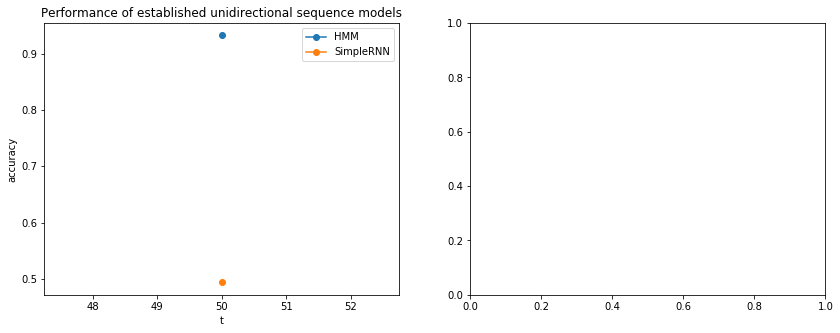

In [15]:
#  single plot
somemodelnames = ["HMM", "SimpleRNN"] #, "LSTM", "GRU", "ad hoc"]
fig, ax = plt.subplots(1,2, figsize=(14, 5))
for j, direction in enumerate(directions):
    for i, model in enumerate(somemodelnames):
        avg_test_acc = np.mean(test_accs[(model, direction)], axis = 1)
        ax[j].plot(ts, avg_test_acc, 'o-', label = model)
    ax[j].set_title('Performance of established ' + ("bidirectional" if direction else "unidirectional") + " sequence models" )
    ax[j].set_xlabel("t")
    ax[j].set_ylabel("accuracy");
    ax[j].legend()
print ('Accuracy was averaged over ' + str(num_reps) + ' repetitions')
fig.savefig('failing1.pdf') 

In [20]:
modelnames

['HMM', 'SimpleRNN']

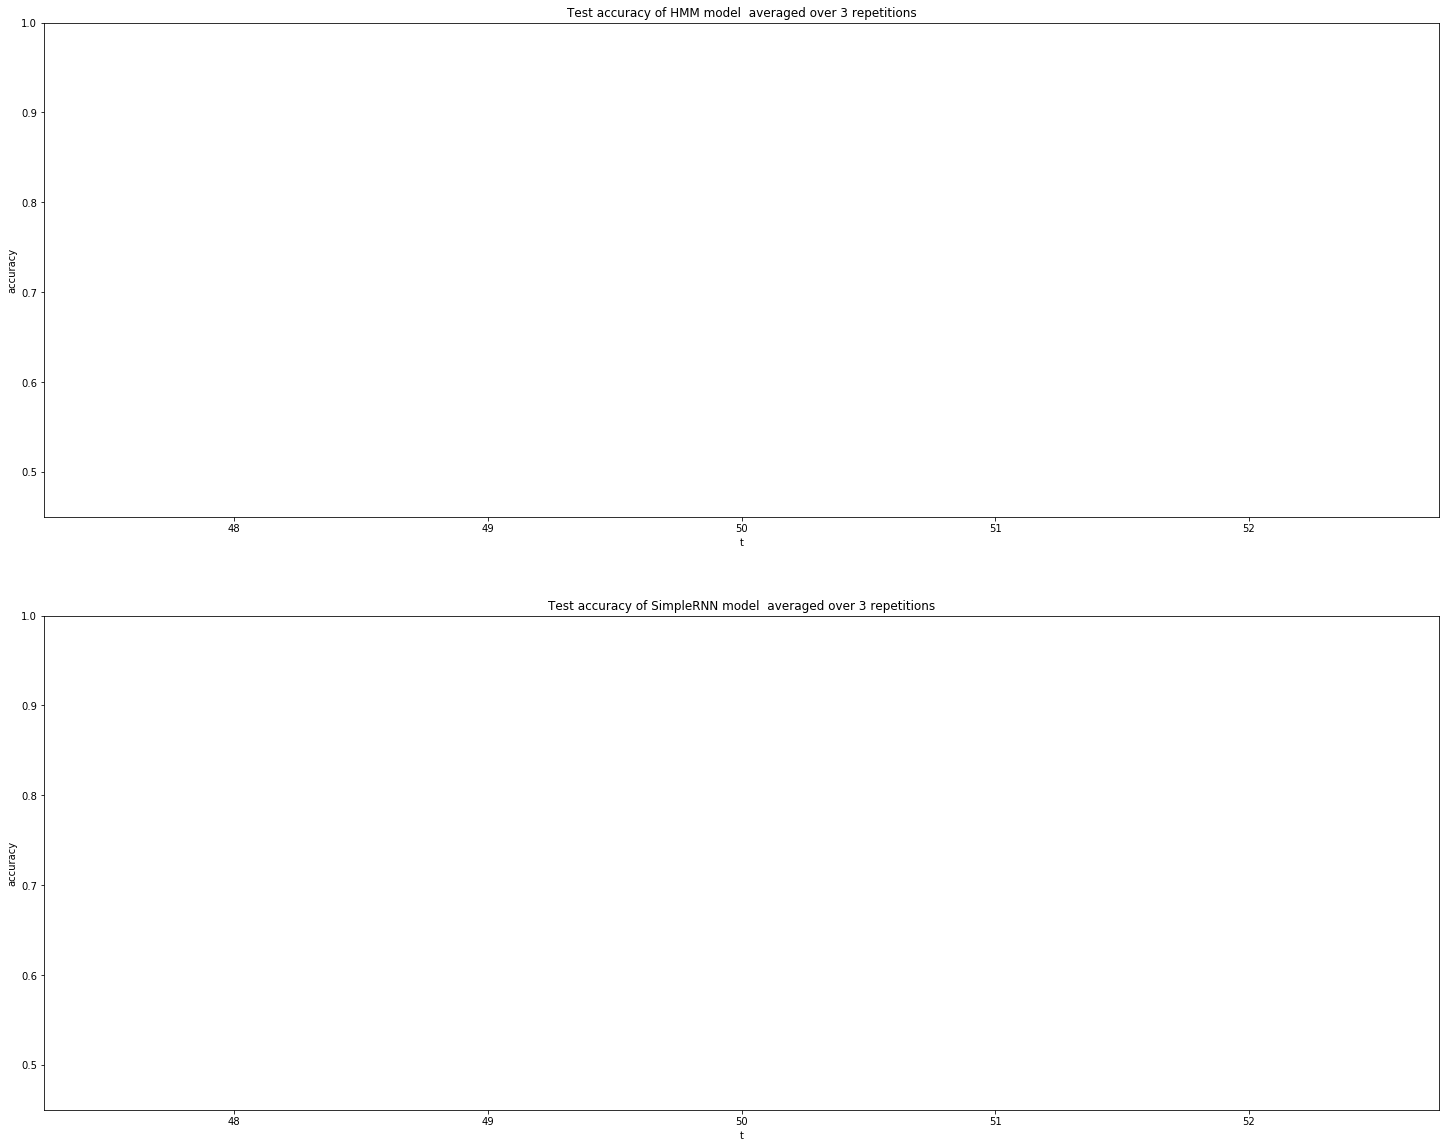

In [21]:
# one plot each
fig, ax = plt.subplots(len(modelnames), len(directions), squeeze=False, figsize=(25,20))
for i, model in enumerate(modelnames):
    for j, direction in enumerate(directions):
        avg_test_acc = np.mean(test_accs[(model, direction)], axis = 1)
        ax[i,j].plot(ts, avg_test_acc)
        ax[i,j].set_ylim([.45, 1])
        ax[i,j].set_title('Test accuracy of ' + model + ' model ' + ("(Bidirectional)" if direction else "") + ' averaged over ' + str(num_reps) + ' repetitions')
        ax[i,j].set_xlabel("t")
        ax[i,j].set_ylabel("accuracy");

In [18]:
fig.savefig('failing.pdf') 